In [29]:
import pandas as pd
from model.PrepareData import PrepareData
import re
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


In [30]:
topn = 50
ngrams = [1,2,3,4]

In [31]:
def raw_chords_to_df(tunes, remove_root=False):
  tunes_chords = [item for tune in tunes for item in tune]

  if remove_root:
    tunes_chords = [re.sub('[A-G][#b]?', '*', chord) for chord in tunes_chords]

  counts = Counter(tunes_chords)
  _df = pd.DataFrame(counts.items(),
                    columns=['chord', 'count']).sort_values(by='count', ascending=False)

  return _df


In [32]:
def plot_zipf(chords):
    counter_of_words = chords.set_index('chord').to_dict(orient='dict')
    counter_of_words = Counter(counter_of_words['count'])

    word_counts = sorted(counter_of_words.values(), reverse=True)
    frequency_rank = np.array(list(range(1, len(word_counts) + 1)))

    plt.figure(figsize=(20, 3))

    plt.subplot(1, 2, 1)

    n = 30
    df_top = chords.head(n)
    plt.bar(df_top['chord'], np.log(df_top['count']))
    plt.xlabel('')
    plt.ylabel('Absolute Counts (log)')
    plt.title(f'Top {n} Most Frequent Chords in the Corpus')
    ax = plt.gca()
    ax.set_xticklabels(labels=chords['chord'],rotation=90)

    plt.subplot(1, 2, 2)

    plt.scatter(np.log(frequency_rank), np.log(word_counts))
    plt.xlabel('Frequency Rank of Token (log)')
    plt.ylabel('Absolute Count of Token (log)')
    plt.title('Zipf Plot for Chord Frequencies')

    #plt.savefig('plot.png')
    return plt


In [33]:
def corpus_chord_ngram(obj, ngrams):
    _df = pd.DataFrame(columns=['sectionid', 'chords'])
    list_corpus_chords = []
    list_sectionid = []

    # for each unique section of a tune, process the chords
    for _id, line in obj.df_section.iterrows():
        sectionid = line['sectionid']
        tune_n = obj.preprocess_input(line['chords'], ngrams=ngrams)

        list_corpus_chords.append(tune_n)
        list_sectionid.append(sectionid)

    _df = pd.DataFrame(list(zip(list_sectionid, list_corpus_chords)),
                       columns=['sectionid', 'chords'])
    _df = _df.set_index('sectionid')
    return _df

In [34]:
def plot_distribution(df, root_removed=False):
    df.sort_values(by=['count'], ascending=False, inplace=True)
    df_top = df.head(topn)

    if len(df_top) > topn:
        text = f'Only the top {topn} chords are shown.'
    else:
        text = f'All chords are shown.'

    if root_removed:
        text2 = f', with Root removed.'
    else:
        text2 = ''

    fig = px.bar(df_top,
                 x='chord',
                 y='count',
                 log_y=True,
                 width=600, height=300,
                 )
    fig.update_layout(
        barmode='stack',
        xaxis={'categoryorder':'total descending'},
        title={'text': f"Absolute Counts of {chords_preprocess} Chords{text2}<br><sup>{text}</sup>",
               'font': {'size': 12}
               },
        xaxis_title="",
        yaxis_title="Count (logarithmic)",
        margin=dict(l=0, r=20, t=20, b=20),
        font=dict(
            size=8,
        ),
        plot_bgcolor="white",
    )
    fig.show()



# Read Full Chords

In [35]:
chords_preprocess = 'chordsFull'
prep = PrepareData(chords_preprocess, ngrams=ngrams)
df = corpus_chord_ngram(prep, prep.ngrams)
df = df['chords']

Train Corpus: 3078
Test Corpus: 180


### Prepare Overview for Full Chords, any Root

In [36]:
df_chords = raw_chords_to_df(df)
df_chords.head()

,chord,count
5,G7,4838
14,Dm7,3960
0,CM7,2590
29,Dm7-G7,2555
207,C,2129


In [37]:
df_chords.tail()

,chord,count
16961,G9-Gaug7-Em7,1
16960,G9-G9-Gaug7,1
16959,G7-G9-G9,1
16958,Ebdim7-G7-G9,1
37787,Em-B7-Dm7-G7,1


C:\Users\doris\AppData\Local\Temp/ipykernel_19680/629062231.py:19: UserWarning:

FixedFormatter should only be used together with FixedLocator



<module 'matplotlib.pyplot' from 'c:\\programdata\\anaconda3\\envs\\chords\\lib\\site-packages\\matplotlib\\pyplot.py'>

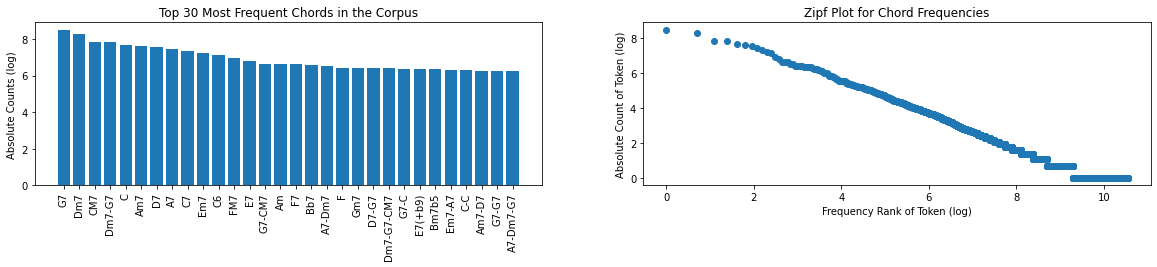

In [38]:
plot_zipf(df_chords)


In [39]:
plot_distribution(df_chords)


### Prepare Overview for Full Chords, Roots removed

In [40]:
df_noroot = raw_chords_to_df(df, remove_root=True)
df_noroot.head(50)


,chord,count
1,*7,13830
2,*m7,9830
6,*m7-*7,5485
0,*M7,4905
125,*7-*7,4422
108,*,3213
5,*7-*m7,2828
133,*7-*7-*7,2486
10,*7-*m7-*7,2078
30,*m7-*m7,2078


In [41]:
df_noroot.head(10)

,chord,count
1,*7,13830
2,*m7,9830
6,*m7-*7,5485
0,*M7,4905
125,*7-*7,4422
108,*,3213
5,*7-*m7,2828
133,*7-*7-*7,2486
10,*7-*m7-*7,2078
30,*m7-*m7,2078


In [42]:
plot_distribution(df_noroot, root_removed=True)


# Read Simplified Chords

In [43]:
chords_preprocess = 'chordsSimplified'
prep = PrepareData(chords_preprocess, ngrams=ngrams)
df = corpus_chord_ngram(prep, prep.ngrams)
df = df['chords']

Train Corpus: 3078
Test Corpus: 180


### Prepare Overview for Simplified Chords, any Root

In [44]:
df_chords = raw_chords_to_df(df)
df_chords.head()


,chord,count
5,G7,5357
14,Dm7,4047
29,Dm7-G7,2744
0,CM7,2660
89,A7,2362


C:\Users\doris\AppData\Local\Temp/ipykernel_19680/629062231.py:19: UserWarning:

FixedFormatter should only be used together with FixedLocator



<module 'matplotlib.pyplot' from 'c:\\programdata\\anaconda3\\envs\\chords\\lib\\site-packages\\matplotlib\\pyplot.py'>

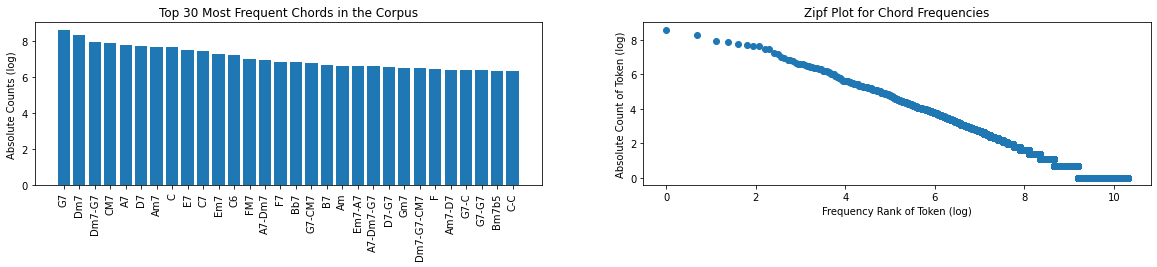

In [45]:
plot_zipf(df_chords)


In [46]:
plot_distribution(df_chords)

### Prepare Overview for Simplified Chords, Roots removed

In [47]:
df_noroot = raw_chords_to_df(df, remove_root=True)

In [48]:
df_noroot.head(10)

,chord,count
1,*7,17382
2,*m7,10230
6,*m7-*7,6407
37,*7-*7,5581
0,*M7,5232
5,*7-*m7,4001
95,*,3233
118,*7-*7-*7,3088
10,*7-*m7-*7,2967
29,*m7-*m7,2270


In [49]:
plot_distribution(df_noroot, root_removed=True)




# Read Basic Chords

In [50]:
chords_preprocess = 'chordsBasic'
prep = PrepareData(chords_preprocess, ngrams=ngrams)
df = corpus_chord_ngram(prep, prep.ngrams)
df = df['chords']

Train Corpus: 3078
Test Corpus: 180


### Prepare Overview for Basic Chords, any Root

In [51]:
df_chords = raw_chords_to_df(df)
df_chords.head()


,chord,count
0,C,6119
5,G7,5360
14,Dm,4392
12,Am,3155
29,Dm-G7,2790


C:\Users\doris\AppData\Local\Temp/ipykernel_19680/629062231.py:19: UserWarning:

FixedFormatter should only be used together with FixedLocator



<module 'matplotlib.pyplot' from 'c:\\programdata\\anaconda3\\envs\\chords\\lib\\site-packages\\matplotlib\\pyplot.py'>

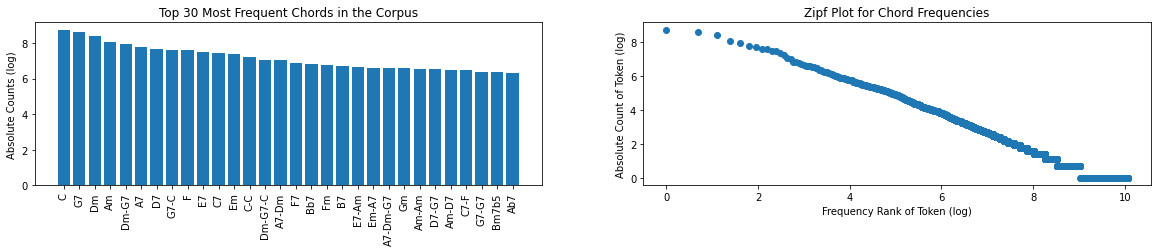

In [52]:
plot_zipf(df_chords)


In [53]:
plot_distribution(df_chords)

### Prepare Overview for Basic Chords, Roots removed

In [54]:
df_noroot = raw_chords_to_df(df, remove_root=True)

In [55]:
df_noroot.head(10)

,chord,count
1,*7,17388
2,*m,12379
0,*,10219
6,*m-*7,6997
37,*7-*7,5587
5,*7-*m,4653
4,*7-*,4071
29,*m-*m,3309
10,*7-*m-*7,3206
102,*7-*7-*7,3090


In [56]:
plot_distribution(df_noroot, root_removed=True)

